In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
import torch.optim as optim

import matplotlib.pyplot as plt

from torchinfo import summary

import time
import random 


import data_utils.pulse as pulse
import models.tools as models_tools
import models.vae as models_vae
import models.fcnn as models_fcnn
import models.rf as rf
#import models.fcnn as fcnn

import data_utils.data_analysis as data_analysis

In [2]:
filename='datasets/galadriel_dataset_24_09_18_high_res.h5'
df_input,df_time_val,df_time,df_freq_val,df_freq_int = data_analysis.read_dataset(filename)

Input DF
      shot number   order2   order3     order4  goodness
0          163165  34400.0 -23000.0 -5500000.0  0.945039
1          163166  34400.0 -23000.0 -5500000.0  0.862834
2          163167  34400.0 -23000.0 -5500000.0  0.834347
3          163168  34400.0 -23000.0 -5500000.0  0.873099
4          163169  34400.0 -23000.0 -5500000.0  0.851336
...           ...      ...      ...        ...       ...
9498       172664  35400.0  28000.0 -4000000.0  1.031447
9499       172665  35400.0  28000.0 -4000000.0  1.031718
9500       172666  35400.0  28000.0 -4000000.0  1.009015
9501       172667  35400.0  28000.0 -4000000.0  1.199801
9502       172668  35400.0  28000.0 -4000000.0  1.241150

[9503 rows x 5 columns]
----
Time values
0    -104.962227
1     -94.466005
2     -83.969782
3     -73.473559
4     -62.977336
5     -52.481114
6     -41.984891
7     -31.488668
8     -20.992445
9     -10.496223
10      0.000000
11     10.496223
12     20.992445
13     31.488668
14     41.984891
15     52.

In [3]:
df_spec_freq=pd.read_hdf(filename,'df_spec_freq')
df_spec_int=pd.read_hdf(filename,'df_spec_int')
df_spec_phase=pd.read_hdf(filename,'df_spec_phase')

In [4]:
#HR pulse have been already generated in a different notebook (vae_conditional.ipynb) no need to redo it

In [5]:
filename_pulse='datasets/pulse_240918.h5'

In [6]:
#read the data
df_time_50=pd.read_hdf(filename_pulse,'df_time_50',mode='r')
df_pulse_50=pd.read_hdf(filename_pulse,'df_pulse_50')
t_50=df_time_50.to_numpy()

df_time_200=pd.read_hdf(filename_pulse,'df_time_200')
df_pulse_200=pd.read_hdf(filename_pulse,'df_pulse_200')
t_200=df_time_200.to_numpy()

### Drop the shots with 'bad' goodness

In [7]:
df_input_reduced=df_input[df_input['goodness']>1.1]

good_shots_list=df_input_reduced.index.values
#print(good_shots_list)
df_pulse_200_reduced=df_pulse_200.iloc[good_shots_list]

#reset the index
df_input_reduced.reset_index(inplace=True,drop=True)
df_pulse_200_reduced.reset_index(inplace=True,drop=True)

In [8]:
df_input_reduced

,shot number,order2,order3,order4,goodness
0,163182,34400.0,-23000.0,-4900000.0,1.428754
1,163185,34400.0,-23000.0,-4900000.0,1.443683
2,163186,34400.0,-23000.0,-4900000.0,1.103443
3,163188,34400.0,-23000.0,-4900000.0,1.418891
4,163189,34400.0,-23000.0,-4600000.0,1.335844
...,...,...,...,...,...
5349,172661,35400.0,28000.0,-4000000.0,1.244578
5350,172662,35400.0,28000.0,-4000000.0,1.225033
5351,172663,35400.0,28000.0,-4000000.0,1.205895
5352,172667,35400.0,28000.0,-4000000.0,1.199801


In [9]:
#split the dataset (X:dazzler param, Y:wizzler)
#all shots 
#X_train, X_test, y_train, y_test=models_tools.split_dataset_roundtrip(df_input,df_pulse_200,rand_split=False)
X_train, X_test, y_train, y_test=models_tools.split_dataset_roundtrip(df_input_reduced,df_pulse_200_reduced,rand_split=False)

## Train a FWD Random Forest model

In [10]:
def train_forward(X_train, X_test, y_train, y_test):
    #Reset the index on y_test to have the same indexes as y_predict
    y_test_reset=y_test.reset_index(drop=True)

    #train forward model with Random forest
    n_estimators = 300
    max_features = 1.0#'sqrt'
    max_depth=20
    random_state=18

    forward_model_rf=rf.fit_random_forest(X_train,y_train,n_estimators, max_features,max_depth, random_state=18)

    y_predict_forward=rf.make_rf_prediction(forward_model_rf,X_test)

    #study the erro distribution
    #df_error_forward_rf=abs(y_test_reset-y_predict_forward)
    #df_error_forward_rf=df_error_forward_rf.sum(axis=1)/y_test.shape[1] #sum error / num columns

    return forward_model_rf#,df_error_forward_rf

In [11]:
%%time
forward_model_rf=train_forward(X_train, X_test, y_train, y_test)

CPU times: user 5.69 s, sys: 236 ms, total: 5.93 s
Wall time: 5.93 s


# Build the CVAE model

In [12]:
# set the device we will be using to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device="cpu"
print("We are using:",device)

We are using: cpu


In [13]:
#define the model
total_in=len(t_200)+len(X_train.columns) #number of input: pulse+Dazz
out_dim=len(X_train.columns)#dazz coefficients
model=models_vae.ConditionalVAE(
    in_pulse_features=len(t_200),
    num_param=out_dim,
    latent_dim=10,
    hidden_dims_enc=[int(total_in*2),int(total_in*3),int(total_in),int(total_in/2),int(total_in/4)],
    hidden_dims_dec=[int(total_in*2),int(total_in*3),total_in,int(total_in*0.5),int(total_in/3),out_dim]
    #hidden_dims_enc=[int(total_in*1.2),int(total_in*2),int(total_in),int(total_in/2),int(total_in/4)],
    #hidden_dims_dec=[int(total_in*1.2),int(total_in*2),total_in,int(total_in*0.5),int(total_in/3),out_dim]
)

batch_size = 10#just as an example
y_length=len(t_200)
x_length=len(X_train.columns)
#summary(model,[(batch_size,y_length),(batch_size,x_length)])
summary(model,[(batch_size,x_length),(batch_size,y_length)])

Layer (type:depth-idx)                   Output Shape              Param #
ConditionalVAE                           [10, 3]                   --
├─Sequential: 1-1                        [10, 51]                  --
│    └─Sequential: 2-1                   [10, 408]                 --
│    │    └─Linear: 3-1                  [10, 408]                 83,640
│    │    └─LeakyReLU: 3-2               [10, 408]                 --
│    └─Sequential: 2-2                   [10, 612]                 --
│    │    └─Linear: 3-3                  [10, 612]                 250,308
│    │    └─LeakyReLU: 3-4               [10, 612]                 --
│    └─Sequential: 2-3                   [10, 204]                 --
│    │    └─Linear: 3-5                  [10, 204]                 125,052
│    │    └─LeakyReLU: 3-6               [10, 204]                 --
│    └─Sequential: 2-4                   [10, 102]                 --
│    │    └─Linear: 3-7                  [10, 102]                 20,9

In [14]:
model_cvae,train_error,test_error=models_vae.train_vae(y_train,y_test,X_train,X_test,
			model,device,n_epochs=300,batch_size=32,print_freq=50,learning_rate=0.002)

Training on: cpu
Finished epoch 0,latest loss 0.5683674812316895
Finished epoch 50,latest loss 0.03483719751238823
Finished epoch 100,latest loss 0.02638082392513752
Finished epoch 150,latest loss 0.02517567202448845
Finished epoch 200,latest loss 0.018219735473394394
Finished epoch 250,latest loss 0.015123252756893635
Finished epoch 299,latest loss 0.011357596144080162
Total time taken to train the model: 191.49s


Text(0.5, 0, 'Epoch')

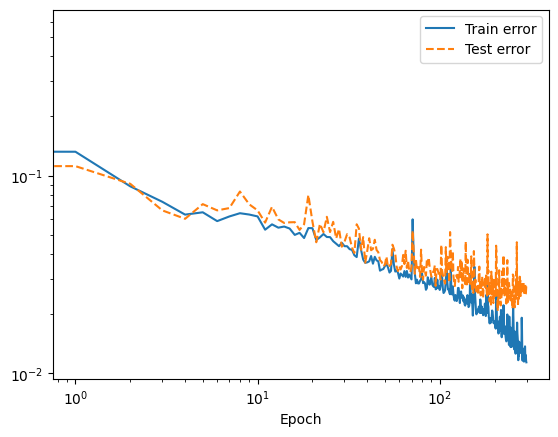

In [15]:
plt.plot(train_error[0],label='Train error')
plt.plot(test_error[0],linestyle='--',label='Test error')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Epoch')

### Train other models

**Random Forest(Roundtrip)**

In [16]:
%%time
roundmodel_rf=rf.ROUNDmodelRF(X_train,X_test,y_train,y_test)
roundmodel_rf.train()
y_predict_round_rf=roundmodel_rf.predict(y_test)
mae_error_round_rf=roundmodel_rf.error_calc()

Training the Random Forest forward model
Training the Random Forest backward model
Calculating the Mean Absolute Error
CPU times: user 2min 37s, sys: 236 ms, total: 2min 37s
Wall time: 2min 37s


/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


**Neural network**

In [17]:
#round model NN
roundmodelNN=models_fcnn.ROUNDmodelNN(X_train,y_train,X_test,y_test,device)
roundmodelNN.train(300,#epochs FWD
                 128,#batch size FWD
                 20, #print freq FWD
                 0.001, #learning rate FWF
                   600,#epochs  BWD
                 128,#batch size BWD
                 50, #print freq BWD
                 0.001) #learning rate BWD
y_predict_nn_round=roundmodelNN.predict(y_test)
error_round_model_nn=roundmodelNN.error_calc_mae()

Training the forward model
Finished epoch 0,latest loss 0.031716883182525635
Finished epoch 20,latest loss 0.0012160241603851318
Finished epoch 40,latest loss 0.0010687689064070582
Finished epoch 60,latest loss 0.0009974775603041053
Finished epoch 80,latest loss 0.0009380365372635424
Finished epoch 100,latest loss 0.0008976637618616223
Finished epoch 120,latest loss 0.0008644118788652122
Finished epoch 140,latest loss 0.0008402859675697982
Finished epoch 160,latest loss 0.0008184500620700419
Finished epoch 180,latest loss 0.0008016517967917025
Finished epoch 200,latest loss 0.0007841518381610513
Finished epoch 220,latest loss 0.0007659358670935035
Finished epoch 240,latest loss 0.0007521594525314867
Finished epoch 260,latest loss 0.000737277208827436
Finished epoch 280,latest loss 0.0007315180264413357
Finished epoch 299,latest loss 0.0007286563632078469
Total time taken to train the model: 108.20s
Training the backward model
Finished epoch 0,latest loss 1.0196298360824585
Finished epo

### Custom shot

In [29]:
#Take a pulse shpae (y_ex) and get the predicted Dazz from CVAE. Uses a FWD RF to predict the pulse shape
# X_train in the input is the dataset used to normalized the X
def pred_from_cvae(y_ex,model_cvae,forward_model_rf,
                   roundmodel_rf,roundmodelNN,
                   df_input,t_200,X_train,device):
    y_ex_tensor=torch.tensor(y_ex,dtype=torch.float32)
    y_ex_tensor=torch.reshape(y_ex_tensor,(1,201))


    #Build the distributions functions P(D|p*)
    num_samples=10000
    dazz_norm=model_cvae.sample(num_samples,y_ex_tensor,device).detach().cpu().numpy()
    dazz_out=models_vae.renorm_data(dazz_norm,X_train)

    dist_order2=dazz_out[:,0]#dazz_out_list[:,0]
    dist_order3=dazz_out[:,1]#dazz_out_list[:,1]
    dist_order4=dazz_out[:,2]#dazz_out_list[:,2]


    num_bins=100

    weights_order2 = (num_bins/4)*np.ones_like(dist_order2) / len(dist_order2)
    weights_input2 = 10*np.ones_like(df_input['order2']) / len(df_input['order2'])

    weights_order3 = (num_bins/4)*np.ones_like(dist_order3) / len(dist_order3)
    weights_input3 = 14*np.ones_like(df_input['order3']) / len(df_input['order3'])

    weights_order4 = (num_bins/4)*np.ones_like(dist_order4) / len(dist_order4)
    weights_input4 = 5*np.ones_like(df_input['order4']) / len(df_input['order4'])

    #predictions from the RF roundtrip model
    y_predict_round_rf=roundmodel_rf.predict([y_ex])[0]
    X_predict_rf=roundmodel_rf.X_predict[0]
    
    y_o2_rf=np.linspace(0,1,10)
    x_o2_rf=np.full_like(y_o2_rf,X_predict_rf[0])

    y_o3_rf=np.linspace(0,1,10)
    x_o3_rf=np.full_like(y_o3_rf,X_predict_rf[1])

    y_o4_rf=np.linspace(0,1,10)
    x_o4_rf=np.full_like(y_o4_rf,X_predict_rf[2])

    #predictions from the NN roundtrip model
    y_predict_round_nn_cust=roundmodelNN.predict(pd.DataFrame([y_ex]))[0]
    X_predict_nn_cust=roundmodelNN.X_predict_nn[0]

    y_o2_nn=np.linspace(0,1,10)
    x_o2_nn=np.full_like(y_o2_nn,X_predict_nn_cust[0])

    y_o3_nn=np.linspace(0,1,10)
    x_o3_nn=np.full_like(y_o3_nn,X_predict_nn_cust[1])

    y_o4_nn=np.linspace(0,1,10)
    x_o4_nn=np.full_like(y_o4_nn,X_predict_nn_cust[2])

    plt.subplot(2, 2, 1)
    plt.hist(dist_order2,bins=num_bins,weights=weights_order2,histtype="step",label=r'Prediction $P(\beta_2|P^*)$',linewidth=4)
    plt.hist(df_input['order2'],bins=11,weights=weights_input2,histtype="step",label=r'$P(\beta_2)$',alpha=0.2,linewidth=3)
    plt.plot(x_o2_rf,y_o2_rf,linestyle='--',label='RF prediction',linewidth=3)
    plt.plot(x_o2_nn,y_o2_nn,linestyle='--',label='MLP prediction',linewidth=3)
    plt.xlabel(r'$\beta_2$',size=15)
    plt.legend(fontsize=14)

    plt.subplot(2, 2, 2)
    plt.hist(dist_order3,bins=num_bins,weights=weights_order3,histtype="step",label=r'Prediction $P(\beta_3|P^*)$',linewidth=4)
    plt.hist(df_input['order3'],bins=18,weights=weights_input3,histtype="step",label=r'$P(\beta_3)$',alpha=0.2,linewidth=3)
    plt.plot(x_o3_rf,y_o3_rf,linestyle='--',label='RF prediction',linewidth=3)
    plt.plot(x_o3_nn,y_o3_nn,linestyle='--',label='MLP prediction',linewidth=3)
    plt.xlabel(r'$\beta_3$',size=15)
    plt.legend(fontsize=14)

    plt.subplot(2, 2, 3)
    plt.hist(dist_order4,bins=num_bins,weights=weights_order4,histtype="step",label=r'Prediction $P(\beta_4|P^*)$',linewidth=4)
    plt.hist(df_input['order4'],bins=6,weights=weights_input4,histtype="step",label=r'$P(\beta_4)$',alpha=0.2,linewidth=3)
    plt.plot(x_o4_rf,y_o4_rf,linestyle='--',label='RF prediction',linewidth=3)
    plt.plot(x_o4_nn,y_o4_nn,linestyle='--',label='MLP prediction',linewidth=3)
    plt.xlabel(r'$\beta_4$',size=15)
    plt.legend(fontsize=14)


    #predictions from the CVAE generative model
    max_prob_o2_ind=np.argmax(np.histogram(dist_order2,bins=num_bins)[0]) #index of the maximum value in the P
    o2_pred=np.histogram(dist_order2,bins=num_bins)[1][max_prob_o2_ind]

    max_prob_o3_ind=np.argmax(np.histogram(dist_order3,bins=num_bins)[0]) #index of the maximum value in the P
    o3_pred=np.histogram(dist_order3,bins=num_bins)[1][max_prob_o3_ind]

    max_prob_o4_ind=np.argmax(np.histogram(dist_order4,bins=num_bins)[0]) #index of the maximum value in the P
    o4_pred=np.histogram(dist_order4,bins=num_bins)[1][max_prob_o4_ind]

    #print(o2_pred,o3_pred,o4_pred)
    y_pred_fwd_cvae=rf.make_rf_prediction(forward_model_rf,pd.DataFrame([(o2_pred,o3_pred,o4_pred)]))[0]

    plt.subplot(2, 2, 4)
    plt.plot(t_200,y_ex,label='Custom shot',linestyle='--')
    plt.plot(t_200,y_pred_fwd_cvae,label='FWD prediction from CVAE coef')
    plt.plot(t_200,y_predict_round_rf,label='Prediction from RF')
    plt.plot(t_200,y_predict_round_nn_cust,label='Prediction from MLP')
    plt.xlabel('t(fs)',size=15)
    plt.legend(fontsize=14)

    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    plt.show()

In [19]:
#define the curve to fit
def func(t,a0, a1,a2,
        b0,b1,b2,
        c0,c1,c2,
        d0,d1,d2,
        e0,e1,e2): 
    #envelope=1*np.exp(-((t-0)**2)/(2*30*30))
    return (a0*np.exp(-((t-a1)**2)/(2*a2*a2))
            +b0*np.exp(-((t-b1)**2)/(2*b2*b2))
           +c0*np.exp(-((t-c1)**2)/(2*c2*c2))
           +d0*np.exp(-((t-d1)**2)/(2*d2*d2))
           +e0*np.exp(-((t-e1)**2)/(2*e2*e2)))

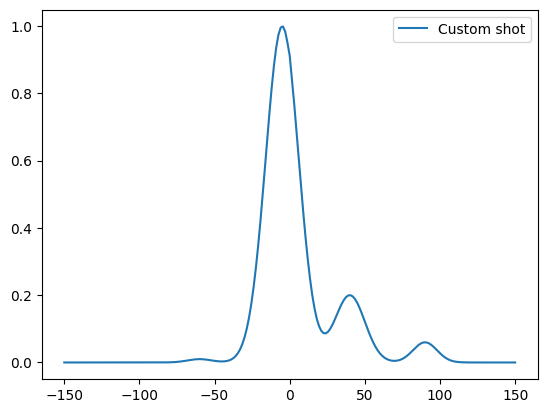

In [20]:
y_cust_shot=func(t_200,1,-5,11,
       0.06,+90,8,
      0.2,+40,10,
      0.01,-60,8,
    0.01,0,0.1)
plt.plot(t_200,y_cust_shot,label='Custom shot')
#plt.plot(t_200,df_pulse_200.iloc[3550],label='Random shot')
plt.legend()

/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


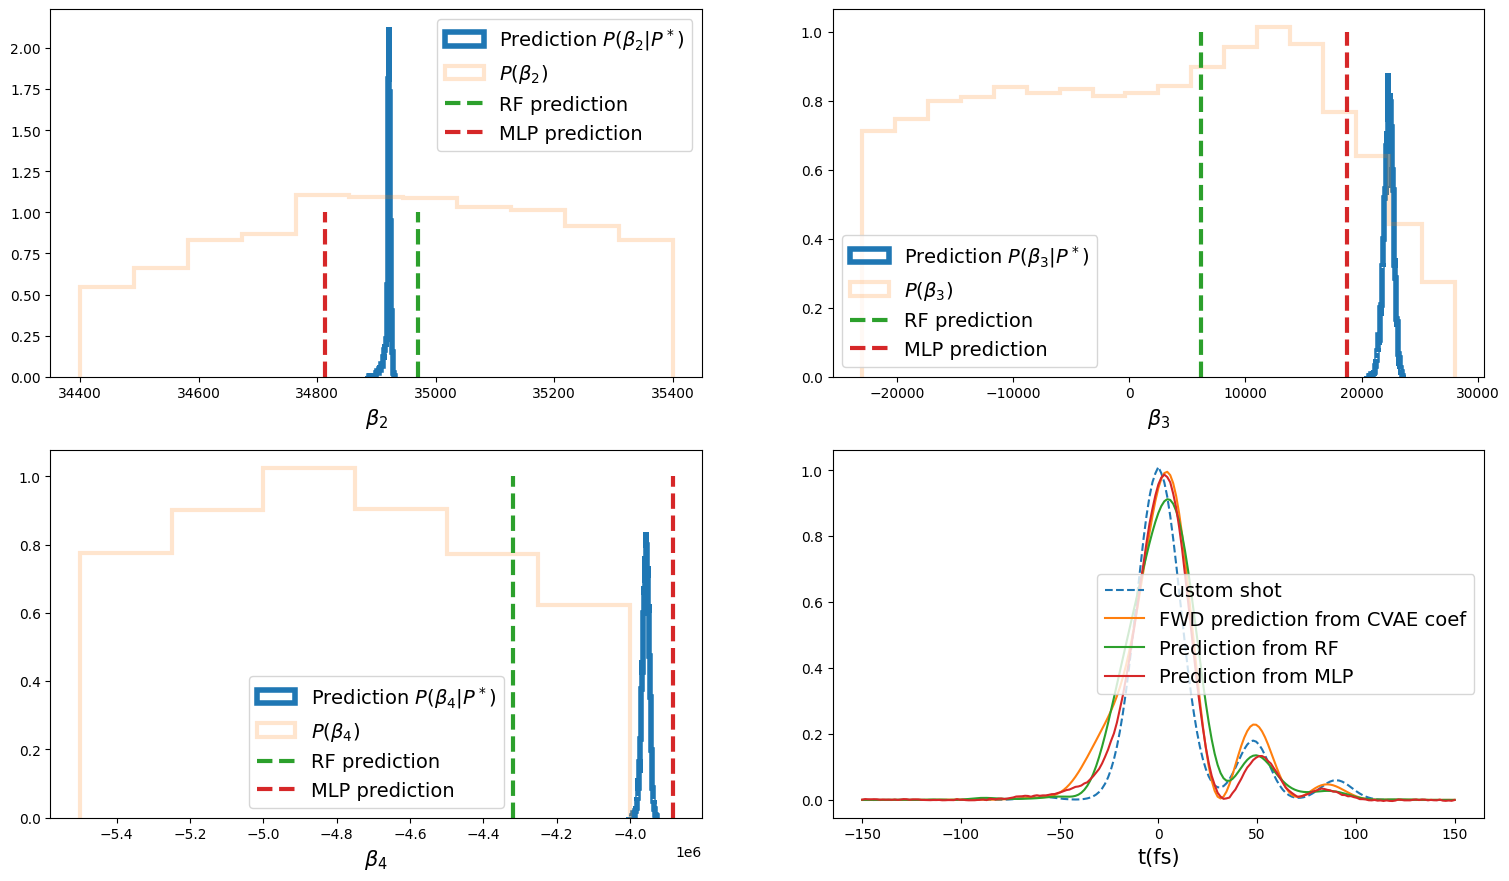

In [30]:
y_cust_shot=func(t_200,1,0,11,
       0.06,+90,8,
      0.18,+48,8,
      0.01,-60,8,
    0.01,0,0.1)

pred_from_cvae(y_cust_shot,model_cvae,forward_model_rf,
               roundmodel_rf,roundmodelNN,
                   df_input_reduced,t_200,X_train,device)

/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


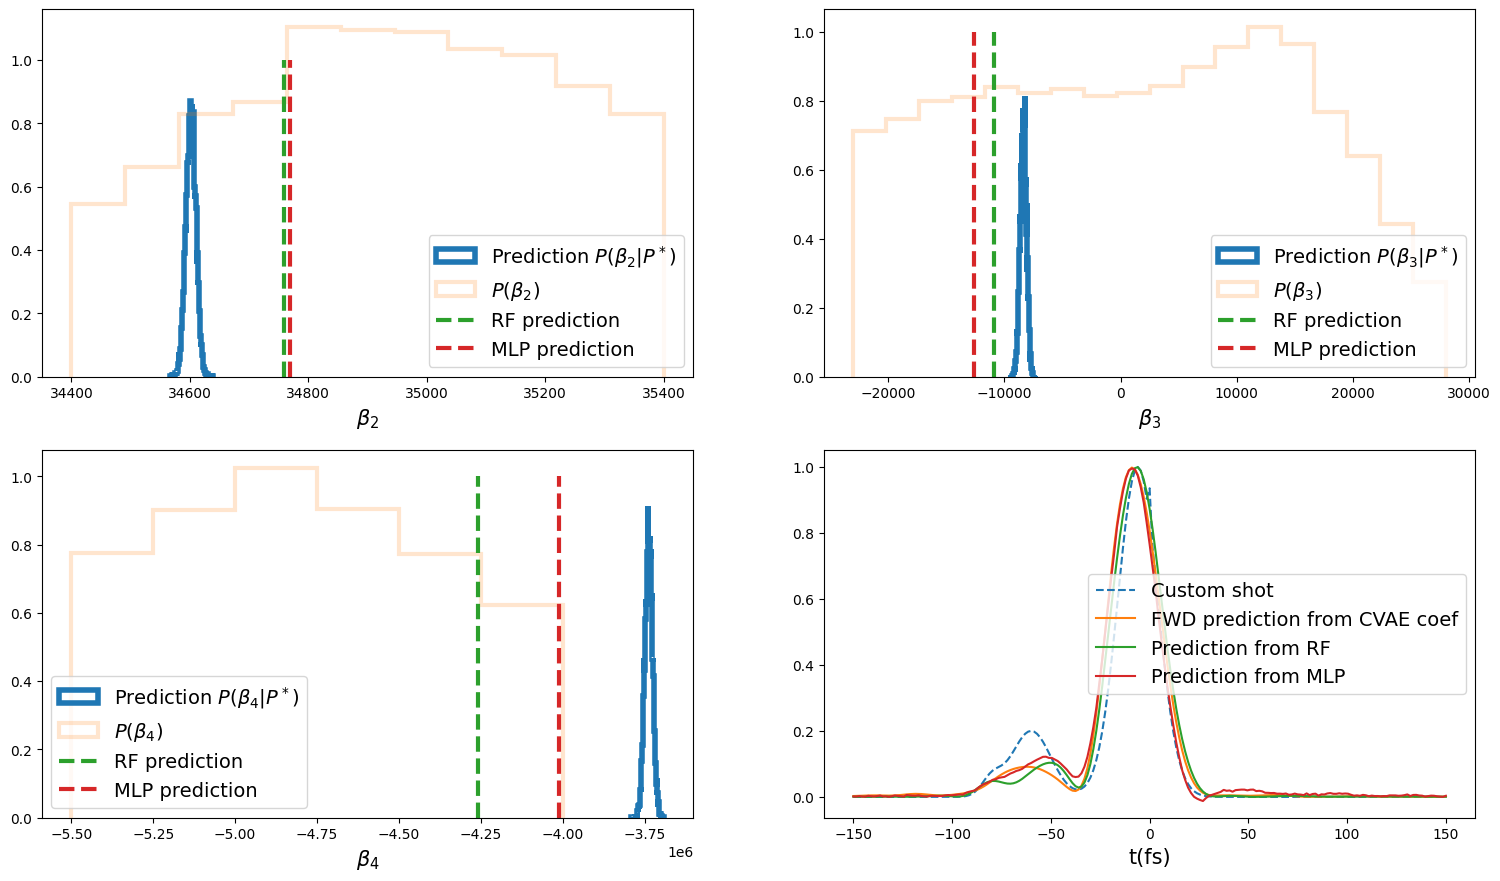

In [31]:
y_cust_shot=func(t_200,1,-6,10,
       0.05,-80,5,
      0.2,-60,10,
      0.,60,8,
    0.1,0,0.1)

pred_from_cvae(y_cust_shot,model_cvae,forward_model_rf,
               roundmodel_rf,roundmodelNN,
                   df_input_reduced,t_200,X_train,device)

/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


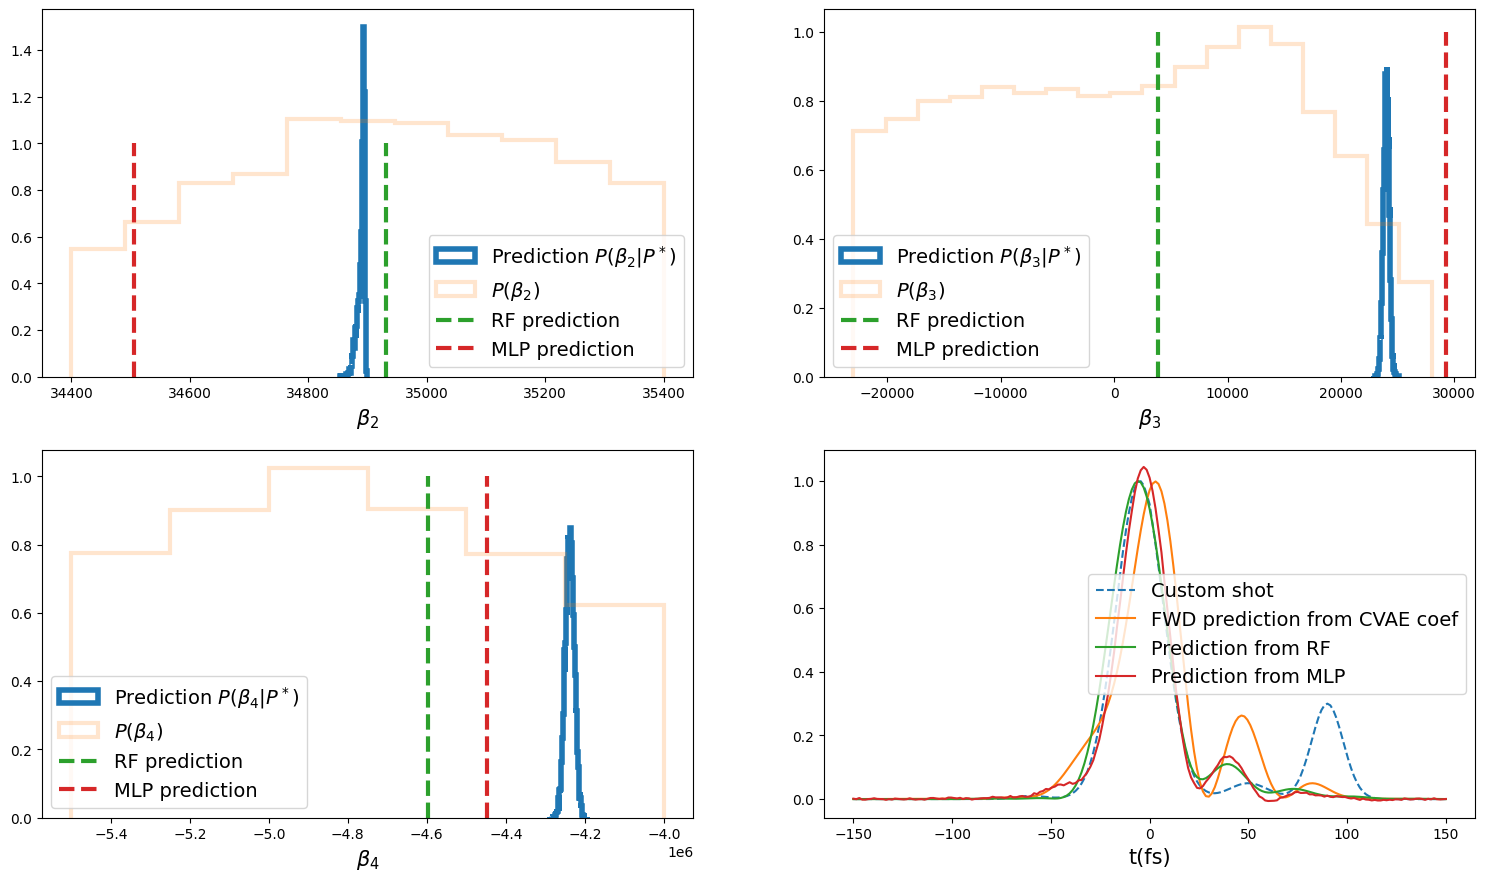

In [33]:
y_cust_shot=func(t_200,1,-5,12,
       0.3,+90,8,
      0.05,+50,10,
      0.01,-60,8,
    0.01,0,0.1)

pred_from_cvae(y_cust_shot,model_cvae,forward_model_rf,
               roundmodel_rf,roundmodelNN,
                   df_input_reduced,t_200,X_train,device)

In [24]:
#Take a pulse shpae (y_ex) and get the predicted Dazz from CVAE. Uses a FWD RF to predict the pulse shape
# X_train in the input is the dataset used to normalized the X
#plot it with Seaborn pairplot
def pred_from_cvae_sns(y_ex,model_cvae,forward_model_rf,
                   roundmodel_rf,roundmodelNN,
                   df_input,t_200,X_train,device):
    y_ex_tensor=torch.tensor(y_ex,dtype=torch.float32)
    y_ex_tensor=torch.reshape(y_ex_tensor,(1,201))


    #Build the distributions functions P(D|p*)
    num_samples=10000
    dazz_norm=model_cvae.sample(num_samples,y_ex_tensor,device).detach().cpu().numpy()
    dazz_out=models_vae.renorm_data(dazz_norm,X_train)

    dist_order2=dazz_out[:,0]#dazz_out_list[:,0]
    dist_order3=dazz_out[:,1]#dazz_out_list[:,1]
    dist_order4=dazz_out[:,2]#dazz_out_list[:,2]

    #print(dist_order2)
    d={'beta2':dist_order2,'beta3':dist_order3,'beta4':dist_order4}
    df_pred_cvae=pd.DataFrame(d)
    g=sns.pairplot(df_pred_cvae,kind="hist",corner=True)
    #g.axes[1,0].set_xlim((34400,35400))
    #g.axes[2,2].set_ylim((-5.4e6,-4e6))
    
    #num_bins=100

    #weights_order2 = (num_bins/4)*np.ones_like(dist_order2) / len(dist_order2)
    #weights_input2 = 10*np.ones_like(df_input['order2']) / len(df_input['order2'])

    #weights_order3 = (num_bins/4)*np.ones_like(dist_order3) / len(dist_order3)
    #weights_input3 = 20*np.ones_like(df_input['order3']) / len(df_input['order3'])

    #weights_order4 = (num_bins/4)*np.ones_like(dist_order4) / len(dist_order4)
    #weights_input4 = 7*np.ones_like(df_input['order4']) / len(df_input['order4'])

    #predictions from the RF roundtrip model
    #y_predict_round_rf=roundmodel_rf.predict([y_ex])[0]
    #X_predict_rf=roundmodel_rf.X_predict[0]
    
    #y_o2_rf=np.linspace(0,1,10)
    #x_o2_rf=np.full_like(y_o2_rf,X_predict_rf[0])

    #y_o3_rf=np.linspace(0,1,10)
    #x_o3_rf=np.full_like(y_o3_rf,X_predict_rf[1])

    #y_o4_rf=np.linspace(0,1,10)
    #x_o4_rf=np.full_like(y_o4_rf,X_predict_rf[2])

    #predictions from the NN roundtrip model
    #y_predict_round_nn_cust=roundmodelNN.predict(pd.DataFrame([y_ex]))[0]
    #X_predict_nn_cust=roundmodelNN.X_predict_nn[0]

    #y_o2_nn=np.linspace(0,1,10)
    #x_o2_nn=np.full_like(y_o2_nn,X_predict_nn_cust[0])

    #y_o3_nn=np.linspace(0,1,10)
    #x_o3_nn=np.full_like(y_o3_nn,X_predict_nn_cust[1])

    #y_o4_nn=np.linspace(0,1,10)
    #x_o4_nn=np.full_like(y_o4_nn,X_predict_nn_cust[2])

    #plt.subplot(2, 2, 1)
    #plt.hist(dist_order2,bins=num_bins,weights=weights_order2,histtype="step",label=r'Prediction $P(\beta_2|P^*)$',linewidth=4)
    #plt.hist(df_input['order2'],bins=60,weights=weights_input2,histtype="step",label=r'$P(\beta_2)$',alpha=0.2,linewidth=3)
    #plt.plot(x_o2_rf,y_o2_rf,linestyle='--',label='RF prediction',linewidth=3)
    #plt.plot(x_o2_nn,y_o2_nn,linestyle='--',label='NN prediction',linewidth=3)
    #plt.xlabel(r'$\beta_2$',size=15)
    #plt.legend(fontsize=14)



    #predictions from the CVAE generative model
    #max_prob_o2_ind=np.argmax(np.histogram(dist_order2,bins=num_bins)[0]) #index of the maximum value in the P
    #o2_pred=np.histogram(dist_order2,bins=num_bins)[1][max_prob_o2_ind]

    #max_prob_o3_ind=np.argmax(np.histogram(dist_order3,bins=num_bins)[0]) #index of the maximum value in the P
    #o3_pred=np.histogram(dist_order3,bins=num_bins)[1][max_prob_o3_ind]

    #max_prob_o4_ind=np.argmax(np.histogram(dist_order4,bins=num_bins)[0]) #index of the maximum value in the P
    #o4_pred=np.histogram(dist_order4,bins=num_bins)[1][max_prob_o4_ind]

    #print(o2_pred,o3_pred,o4_pred)
    #y_pred_fwd_cvae=rf.make_rf_prediction(forward_model_rf,pd.DataFrame([(o2_pred,o3_pred,o4_pred)]))[0]

    #plt.subplot(2, 2, 4)
    #plt.plot(t_200,y_ex,label='Custom shot',linestyle='--')
    #plt.plot(t_200,y_pred_fwd_cvae,label='FWD prediction from CVAE coef')
    #plt.plot(t_200,y_predict_round_rf,label='Prediction from RF')
    #plt.plot(t_200,y_predict_round_nn_cust,label='Prediction from NN')
    #plt.xlabel('t(fs)',size=15)
    #plt.legend(fontsize=14)

    #fig = plt.gcf()
    #fig.set_size_inches(18.5, 10.5)
    #plt.show()

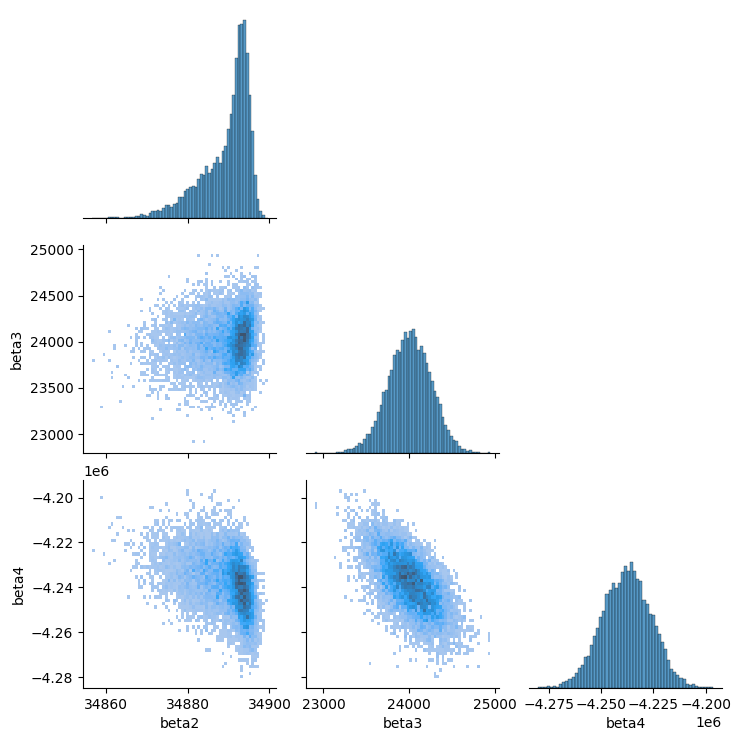

In [25]:
y_cust_shot=func(t_200,1,-5,12,
       0.3,+90,8,
      0.05,+50,10,
      0.01,-60,8,
    0.01,0,0.1)

pred_from_cvae_sns(y_cust_shot,model_cvae,forward_model_rf,
               roundmodel_rf,roundmodelNN,
                   df_input_reduced,t_200,X_train,device)